In [1]:
import numpy as np
import matplotlib.pyplot as plt

We are reading from a sample file we collected using the sensor in the Raspberry Pico.

In [3]:
x = np.loadtxt('samples/readings-30s-finger.txt')
fs = 250 # Sampling frequency of the data
# Create a time vector using the length of the data
t = np.arange(len(x))/fs

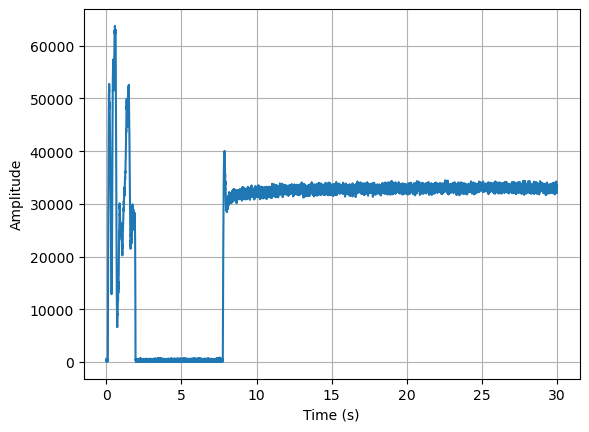

In [4]:
# Show the whole signal
plt.plot(t, x)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.grid()
plt.show()

The round robin algorithm implements a circular buffer: we need a circular buffer to collect the last 100 samples.

In [6]:
class RoundRobin:
    def __init__(self, size):
        self.size = size
        self.buffer = [None] * size
        self.head = 0
        self.tail = 0
        self.is_full = False

    def append(self, item):
        self.buffer[self.head] = item
        self.head = (self.head + 1) % self.size

        if self.is_full:
            self.tail = (self.tail + 1) % self.size

        if self.head == self.tail:
            self.is_full = True

    def get(self):
        if not self.is_full and self.head == self.tail:
            return []  # buffer is empty

        items = []
        idx = self.tail

        while True:
            items.append(self.buffer[idx])
            if idx == self.head - 1 and not (self.is_full and self.head == self.tail):
                break
            idx = (idx + 1) % self.size
            if idx == self.tail:
                break

        return items

    def __len__(self):
        if self.is_full:
            return self.size
        if self.head >= self.tail:
            return self.head - self.tail
        return self.size + self.head - self.tail

In [7]:
# Weight parameter
a = 1/fs

# Initialize the output values to zeros
smoothed = np.zeros(len(x))

# Calculate the output values
for n in range(1, len(x)):
    smoothed[n] = (1-a)*smoothed[n-1] + a*x[n]

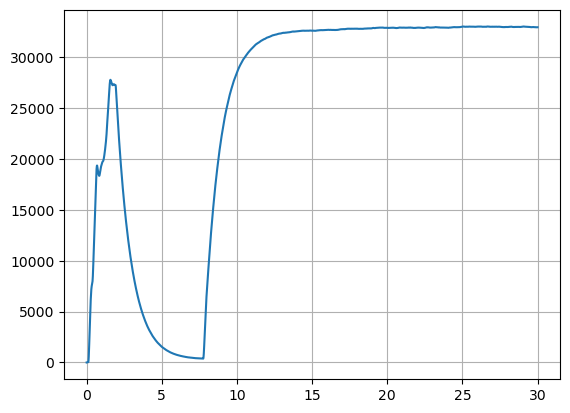

In [8]:
plt.plot(t, smoothed)
plt.grid()
plt.show()

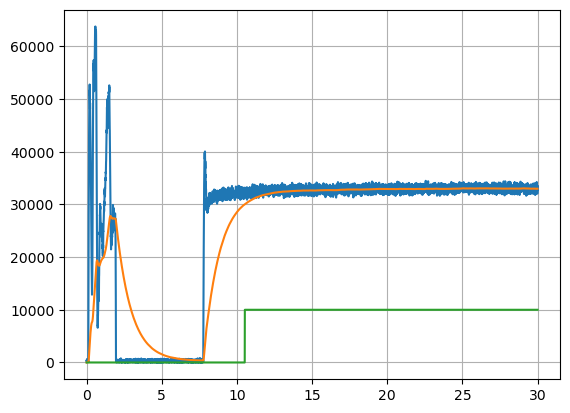

In [9]:
buffer = RoundRobin(50)

finger = []

def detect_finger(buffer):
    for i in buffer:
        if i > 30000: # 30000 is an empirical threshold, needs to be verified in the device
            finger.append(10000)
            return
    finger.append(0)

for i in smoothed:
    buffer.append(i)
    detect_finger(buffer.get())

plt.plot(t, x)
plt.plot(t, smoothed)
plt.plot(t, finger)
plt.grid()
plt.show()